In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')

import sys
sys.path.append('../src') 
from utils import stock_trading_strategy, stock_trading_strategy_supp_resist, plot_trading_strategy, download_stock_df, user_function, plot_candlestick

## Stock to test the support and resistance, and compare with the classic trade strategy
* yinn
* tqqq

In [10]:
from kneed import KneeLocator

def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    print("Optimum K is ", optimum_k+1)
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

def identify_weak_support_resistance(data):
    # Initialize an empty list to store the labels (support, resistance, neither)
    labels = []

    # Iterate through the dataframe to identify weak support and weak resistance
    for i in range(len(data)):
        if i == 0 or i == len(data) - 1:
            # Edge cases where there's no previous or following day
            labels.append("neither")
        elif data['close'][i] < data['close'][i - 1] and data['close'][i] < data['close'][i + 1]:
            # Weak support condition
            labels.append("weak support")
        elif data['close'][i] > data['close'][i - 1] and data['close'][i] > data['close'][i + 1]:
            # Weak resistance condition
            labels.append("weak resistance")
        else:
            # Neither weak support nor weak resistance
            labels.append("neither")

    # Add the labels to a new column in the dataframe
    data['Support/Resistance'] = labels

    return data

[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'yinn')

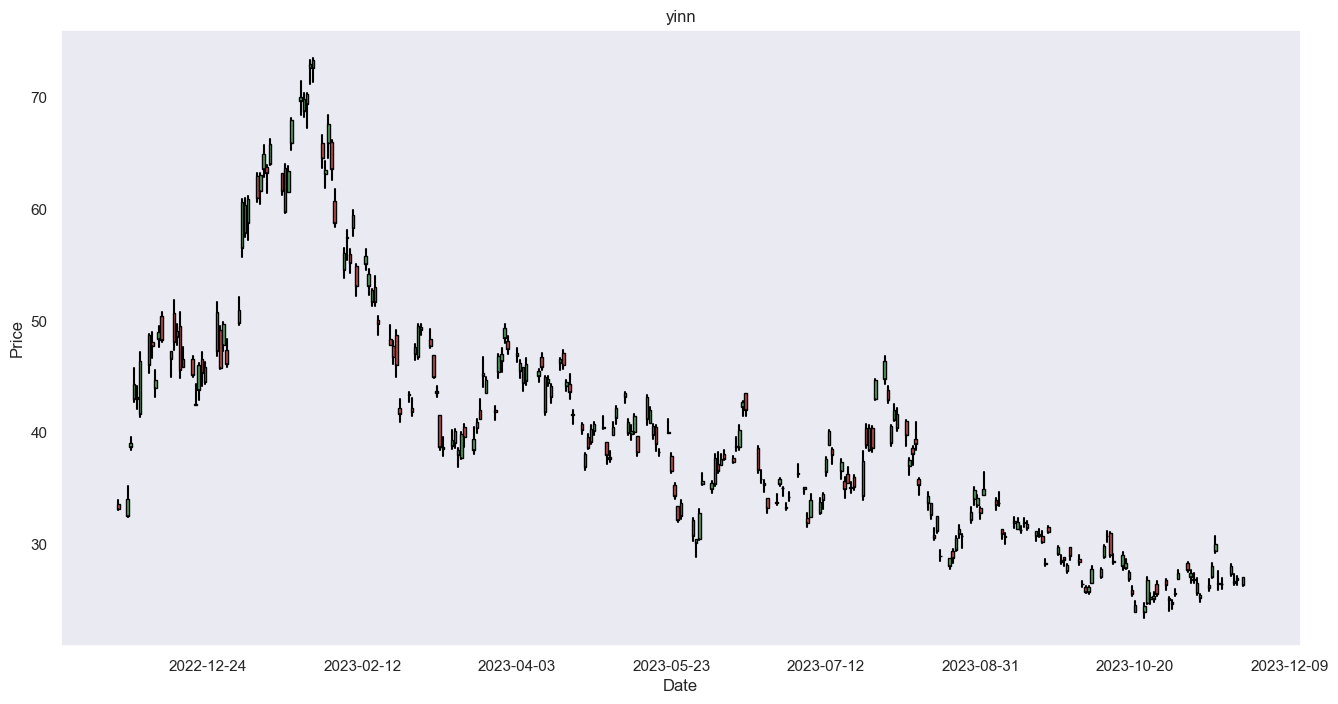

In [14]:
df_yinn = yf.download('yinn'.upper(),
                      start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
                      end=datetime.today().strftime('%Y-%m-%d'))
df_yinn = df_yinn.reset_index()

ax = plot_candlestick(df_yinn)
ax.set_title('yinn')

[*********************100%%**********************]  1 of 1 completed
Optimum K is  10
Optimum K is  10
[[25.76625001]
 [29.43818191]
 [33.50921049]
 [37.69368433]
 [40.61279984]
 [44.21138869]
 [47.87750034]
 [55.39363584]
 [62.32615398]
 [69.3519989 ]]
[[27.02138885]
 [30.9429034 ]
 [34.76656258]
 [38.40576935]
 [41.52249985]
 [46.1138235 ]
 [49.85380954]
 [55.52625036]
 [63.49437499]
 [70.84428733]]


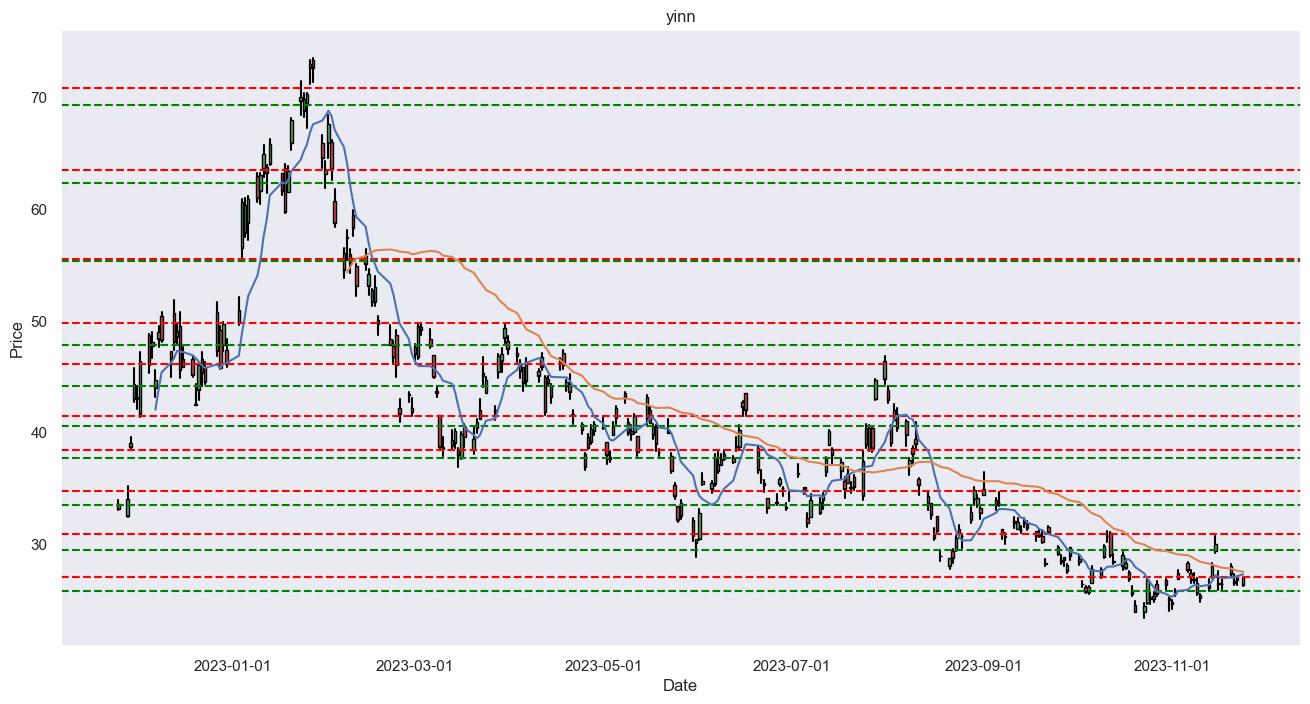

In [15]:
df_yinn = yf.download('yinn'.upper(), start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
                      end=datetime.today().strftime('%Y-%m-%d'))
df_yinn = df_yinn.reset_index()

low_clusters = get_optimum_clusters(df_yinn[['Date',"Low"]].set_index('Date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_yinn[['Date',"High"]].set_index('Date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

ax = plot_candlestick(df_yinn)
ax.set_title('yinn')

print(low_centers)
print(high_centers)

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')

df_yinn['9_MA'] = df_yinn['Close'].rolling(window=9).mean()
    
df_yinn['50_MA'] = df_yinn['Close'].rolling(window=50).mean()
ax.plot(df_yinn['Date'], df_yinn['9_MA'])
ax.plot(df_yinn['Date'], df_yinn['50_MA'])

In [24]:
# Check the size of clusters
# Calculate effective radius for each cluster, using IQR

def calculate_effective_radius(cluster_points, centroid):
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    
    # Calculate interquartile range (IQR)
    q75, q25 = np.percentile(distances, [75 ,25])
    iqr = q75 - q25
    
    # Define effective radius as a multiple of IQR
    effective_radius = 1.5 * iqr
    
    return effective_radius

centroids = low_clusters.cluster_centers_
effective_radii = []
data = df_yinn[['Date',"Low"]].set_index('Date')

for cluster_label in range(low_clusters.n_clusters):
    cluster_points = data[low_clusters.labels_ == cluster_label]
    centroid = centroids[cluster_label]
    
    effective_radius = calculate_effective_radius(cluster_points, centroid)
    effective_radii.append(effective_radius)

print(effective_radii)

[1.1686384894631132, 1.6931246280670145, 1.5749988555908203, 0.8879569455197025, 2.492046702991839, 1.364999771118164, 1.1465618312358803, 1.263749599456787, 1.4849967956542969, 0.7050018310546875]


In [19]:
# records_df, purchase_record = stock_trading_strategy_supp_resist(
#     df_yinn.rename(columns={'Date':'date','Close':'daily_price'}),
#     [e[0] for e in low_centers if e <= df_yinn.iloc[0]['Close']],
#     [e[0] for e in high_centers],
#     initial_cash=10000,
#     investment=1000,
# )
# print(records_df.iloc[-1]['total_cash']+records_df.iloc[-1]['total_num_shares']*records_df.iloc[-1]['daily_price']-10000)
# print(records_df['total_cash'].min())
# records_df[records_df['action']!='Pass']

In [20]:
# result = stock_trading_strategy(df_yinn.rename(columns={'Date':'date','Close':'daily_price'}),
#                                 '2023-05-01',
#                                 datetime.today().strftime('%Y-%m-%d'),
#                                 10000, 1000,
#                                 buy_threshold=0.05,
#                                 sell_threshold=0.1)

# print(result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])
# print(result['total_cash'].min())
# result[result['action']!='Pass'][['date','daily_price','action','total_cash','total_num_shares']]
# # 11024.60529658459
# # 5238.617782091438

In [21]:
# plt.figure(figsize=(16, 8))
# plt.grid(True, alpha=0.5)

# plt.plot(df_yinn['Date'], df_yinn['Close'], label='Daily Close Price')
# # plt.plot(df_yinn['Date'], df_yinn['High'], color='green', label='Highest Price')
# # plt.plot(df_yinn['Date'], df_yinn['Low'], color='red', label='Lowest Price')

# # Shading the region between the highest and lowest prices
# plt.fill_between(df_yinn['Date'], df_yinn['Low'], df_yinn['High'], color='gray', alpha=0.3, label='Daily Price Range')

# result['date'] = pd.to_datetime(result['date'])

# # plot the purchase actions as red dots
# purchases = result[result['action'] == 'Purchase']
# plt.scatter(purchases['date'], purchases['daily_price'], s=100, marker='^', color='green', label='Purchase')

# # plot the sell actions as blue dots
# sells = result[result['action'] == 'Sell']
# plt.scatter(sells['date'], sells['daily_price'], s=100, marker='v', color='red', label='Sell')

# for index, row in sells.iterrows():
#     # plt.text(row['date'], row['daily_price'], row['daily_price'], ha='center', va='bottom')
#     plt.annotate(f"{row['daily_price']:.2f}", xy=(row['date'], row['daily_price']), 
#                  xytext=(row['date'], row['daily_price']*0.98), ha='center', va='top')
# for index, row in purchases.iterrows():
#     # plt.text(row['date'], row['daily_price'], row['daily_price'], ha='center', va='bottom')
#     plt.annotate(f"{row['daily_price']:.2f}", xy=(row['date'], row['daily_price']), 
#                  xytext=(row['date'], row['daily_price']*0.98), ha='center', va='top')

# plt.xlabel('Date')
# plt.ylabel('Stock Price')
# plt.title('Stock Trading Strategy Visualization - default')
# plt.legend()

# plt.show()

In [22]:
# plt.figure(figsize=(16, 8))
# plt.grid(True, alpha=0.5)

# plt.plot(df_yinn['Date'], df_yinn['Close'], label='Daily Close Price')
# # plt.plot(df_yinn['Date'], df_yinn['High'], color='green', label='Highest Price')
# # plt.plot(df_yinn['Date'], df_yinn['Low'], color='red', label='Lowest Price')

# # Shading the region between the highest and lowest prices
# plt.fill_between(df_yinn['Date'], df_yinn['Low'], df_yinn['High'], color='gray', alpha=0.3, label='Daily Price Range')

# records_df['date'] = pd.to_datetime(records_df['date'])

# # plot the purchase actions as red dots
# purchases = records_df[records_df['action'] == 'Purchase']
# plt.scatter(purchases['date'], purchases['daily_price'], s=100, marker='^', color='green', label='Purchase')

# # plot the sell actions as blue dots
# sells = records_df[records_df['action'] == 'Sell']
# plt.scatter(sells['date'], sells['daily_price'], s=100, marker='v', color='red', label='Sell')

# for index, row in sells.iterrows():
#     # plt.text(row['date'], row['action_price'], row['action_price'], ha='center', va='bottom')
#     plt.annotate(f"{row['action_price']:.2f}", xy=(row['date'], row['action_price']), 
#                  xytext=(row['date'], row['action_price']*0.98), ha='center', va='top')
# for index, row in purchases.iterrows():
#     # plt.text(row['date'], row['action_price'], row['action_price'], ha='center', va='bottom')
#     plt.annotate(f"{row['action_price']:.2f}", xy=(row['date'], row['action_price']), 
#                  xytext=(row['date'], row['action_price']*0.98), ha='center', va='top')

# plt.xlabel('Date')
# plt.ylabel('Stock Price')
# plt.title('Stock Trading Strategy Visualization - supp and resist')
# plt.legend()

# plt.show()

In [23]:
# df_tqqq = yf.download('tqqq'.upper(), start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
#                       end=datetime.today().strftime('%Y-%m-%d'))
# df_tqqq = df_tqqq.reset_index()

# low_clusters = get_optimum_clusters(df_tqqq[['Date',"Low"]].set_index('Date'))
# low_centers = low_clusters.cluster_centers_
# low_centers = np.sort(low_centers, axis=0)

# high_clusters = get_optimum_clusters(df_tqqq[['Date',"High"]].set_index('Date'))
# high_centers = high_clusters.cluster_centers_
# high_centers = np.sort(high_centers, axis=0)

# records_df, purchase_record = stock_trading_strategy_supp_resist(
#     df_tqqq.rename(columns={'Date':'date','Close':'daily_price'}),
#     [e[0] for e in low_centers if e <= df_tqqq.iloc[0]['Close']],
#     [e[0] for e in high_centers],
#     initial_cash=10000,
#     investment=1000,
# )
# print(records_df.iloc[-1]['total_cash']+records_df.iloc[-1]['total_num_shares']*records_df.iloc[-1]['daily_price']-10000)
# print(records_df['total_cash'].min())
# records_df[records_df['action']!='Pass']

In [24]:
# result = stock_trading_strategy(df_tqqq.rename(columns={'Date':'date','Close':'daily_price'}),
#                                 (datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
#                                 datetime.today().strftime('%Y-%m-%d'),
#                                 10000, 1000,
#                                 buy_threshold=0.05,
#                                 sell_threshold=0.1)

# print(result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])
# print(result['total_cash'].min())
# result[result['action']!='Pass'][['date','daily_price','action','total_cash','total_num_shares']]

### What if using minute level data?

In [25]:
ticker = yf.Ticker('yinn'.upper())
start = (datetime.today() - relativedelta(days=7)).strftime('%Y-%m-%d')
end = datetime.today().strftime('%Y-%m-%d')
df_yinn_7d = ticker.history(interval='1m', start=start, end=end)
df_yinn_7d = df_yinn_7d.reset_index()
df_yinn_7d.columns = df_yinn_7d.columns.str.lower()
df_yinn_7d

,datetime,open,high,low,close,volume,dividends,stock splits,capital gains
0,2023-11-09 09:30:00-05:00,26.549999,26.610001,26.480000,26.480000,152563,0.0,0.0,0.0
1,2023-11-09 09:31:00-05:00,26.477501,26.479900,26.370001,26.430000,16726,0.0,0.0,0.0
2,2023-11-09 09:33:00-05:00,26.369600,26.379999,26.280001,26.320000,41992,0.0,0.0,0.0
3,2023-11-09 09:34:00-05:00,26.362900,26.500000,26.360001,26.410000,8160,0.0,0.0,0.0
4,2023-11-09 09:35:00-05:00,26.379999,26.420099,26.351101,26.395000,17900,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1938,2023-11-15 15:55:00-05:00,30.020000,30.059900,30.010000,30.049999,18026,0.0,0.0,0.0
1939,2023-11-15 15:56:00-05:00,30.049999,30.070000,30.030001,30.059999,31061,0.0,0.0,0.0
1940,2023-11-15 15:57:00-05:00,30.059999,30.080000,30.040001,30.040001,32436,0.0,0.0,0.0
1941,2023-11-15 15:58:00-05:00,30.035000,30.049999,30.000000,30.040001,14097,0.0,0.0,0.0


Optimum K is  9
Optimum K is  9
[[24.98758011]
 [25.40111152]
 [25.97371668]
 [26.53939988]
 [27.3439854 ]
 [27.77378407]
 [28.11750603]
 [29.5421792 ]
 [30.05431078]
 [30.38504952]]
[[25.05949167]
 [25.45345244]
 [26.03119242]
 [26.56891651]
 [27.39976309]
 [27.80305065]
 [28.14295594]
 [29.65789753]
 [30.12348244]
 [30.56700627]]


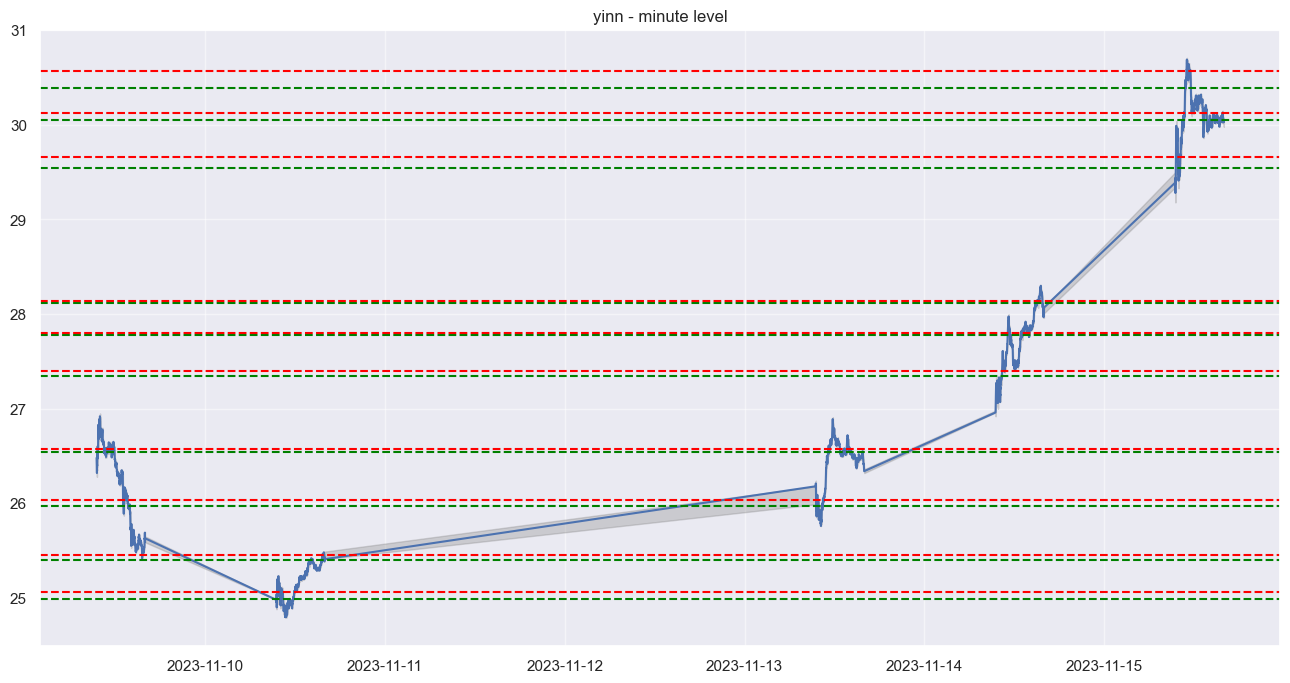

In [26]:
df_yinn_7d['date'] = df_yinn_7d['datetime']
low_clusters = get_optimum_clusters(df_yinn_7d[['datetime',"low"]].set_index('datetime'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_yinn_7d[['datetime',"high"]].set_index('datetime'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

fig, ax = plt.subplots(figsize=(16, 8))
ax.grid(True, alpha=0.5)
ax.set_title('yinn - minute level')

ax.plot(df_yinn_7d['datetime'], df_yinn_7d['close'], label='Minute Close Price')

# Shading the region between the highest and lowest prices
ax.fill_between(df_yinn_7d['datetime'], df_yinn_7d['low'], df_yinn_7d['high'], color='gray', alpha=0.3, label='Minute Price Range')

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')

In [27]:
df_yinn_7d = identify_weak_support_resistance(df_yinn_7d)
df_yinn_7d

,datetime,open,high,low,close,volume,dividends,stock splits,capital gains,date,Support/Resistance
0,2023-11-09 09:30:00-05:00,26.549999,26.610001,26.480000,26.480000,152563,0.0,0.0,0.0,2023-11-09 09:30:00-05:00,neither
1,2023-11-09 09:31:00-05:00,26.477501,26.479900,26.370001,26.430000,16726,0.0,0.0,0.0,2023-11-09 09:31:00-05:00,neither
2,2023-11-09 09:33:00-05:00,26.369600,26.379999,26.280001,26.320000,41992,0.0,0.0,0.0,2023-11-09 09:33:00-05:00,weak support
3,2023-11-09 09:34:00-05:00,26.362900,26.500000,26.360001,26.410000,8160,0.0,0.0,0.0,2023-11-09 09:34:00-05:00,weak resistance
4,2023-11-09 09:35:00-05:00,26.379999,26.420099,26.351101,26.395000,17900,0.0,0.0,0.0,2023-11-09 09:35:00-05:00,weak support
...,...,...,...,...,...,...,...,...,...,...,...
1938,2023-11-15 15:55:00-05:00,30.020000,30.059900,30.010000,30.049999,18026,0.0,0.0,0.0,2023-11-15 15:55:00-05:00,neither
1939,2023-11-15 15:56:00-05:00,30.049999,30.070000,30.030001,30.059999,31061,0.0,0.0,0.0,2023-11-15 15:56:00-05:00,weak resistance
1940,2023-11-15 15:57:00-05:00,30.059999,30.080000,30.040001,30.040001,32436,0.0,0.0,0.0,2023-11-15 15:57:00-05:00,neither
1941,2023-11-15 15:58:00-05:00,30.035000,30.049999,30.000000,30.040001,14097,0.0,0.0,0.0,2023-11-15 15:58:00-05:00,neither


Optimum K is  9
Optimum K is  9
[[24.96400456]
 [25.28277907]
 [25.582556  ]
 [25.97674597]
 [26.53628651]
 [27.36390637]
 [27.87789603]
 [29.50169029]
 [30.04044392]
 [30.35408071]]
[[25.01369054]
 [25.31890568]
 [25.65181621]
 [26.11540949]
 [26.59272084]
 [27.42181377]
 [27.89507146]
 [29.5400001 ]
 [30.12219548]
 [30.56509161]]


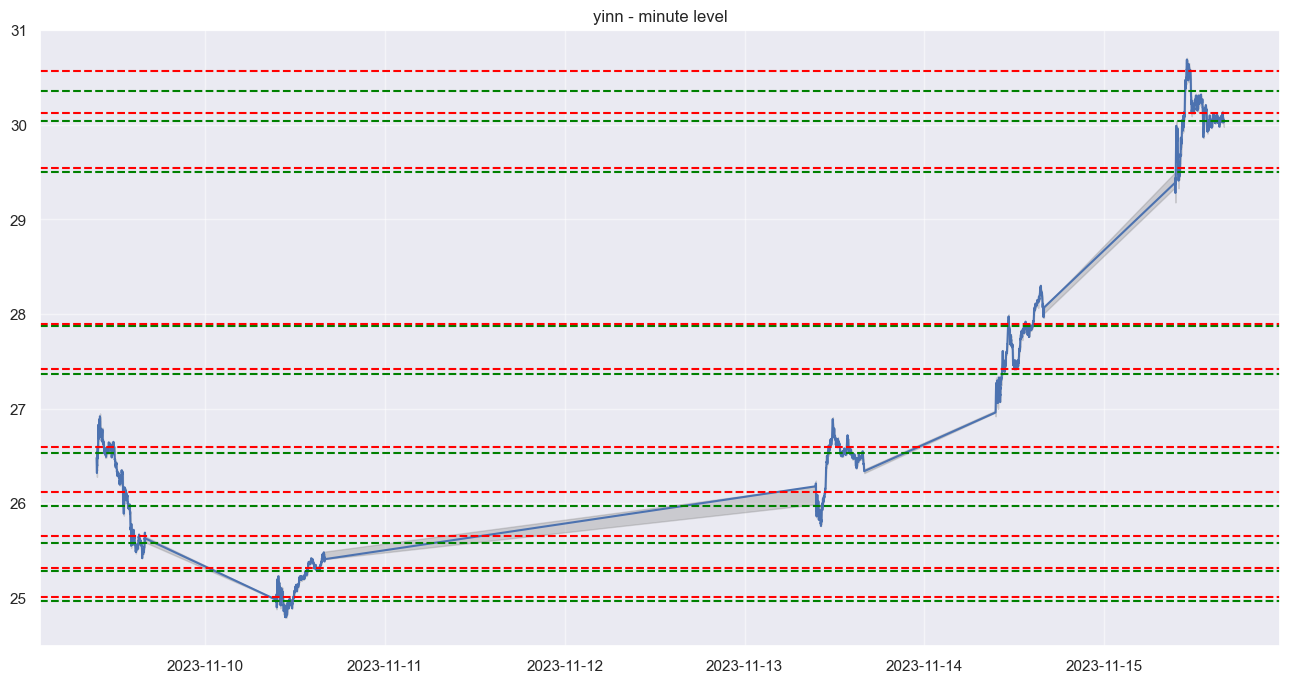

In [28]:
low_clusters = get_optimum_clusters(df_yinn_7d[df_yinn_7d['Support/Resistance']=='weak support'][['date',"close"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_yinn_7d[df_yinn_7d['Support/Resistance']=='weak resistance'][['date',"close"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

fig, ax = plt.subplots(figsize=(16, 8))
ax.grid(True, alpha=0.5)
ax.set_title('yinn - minute level')

ax.plot(df_yinn_7d['datetime'], df_yinn_7d['close'], label='Minute Close Price')

# Shading the region between the highest and lowest prices
ax.fill_between(df_yinn_7d['datetime'], df_yinn_7d['low'], df_yinn_7d['high'], color='gray', alpha=0.3, label='Minute Price Range')

for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')

### Try a different approach to calculate support and resistance

[*********************100%%**********************]  1 of 1 completed


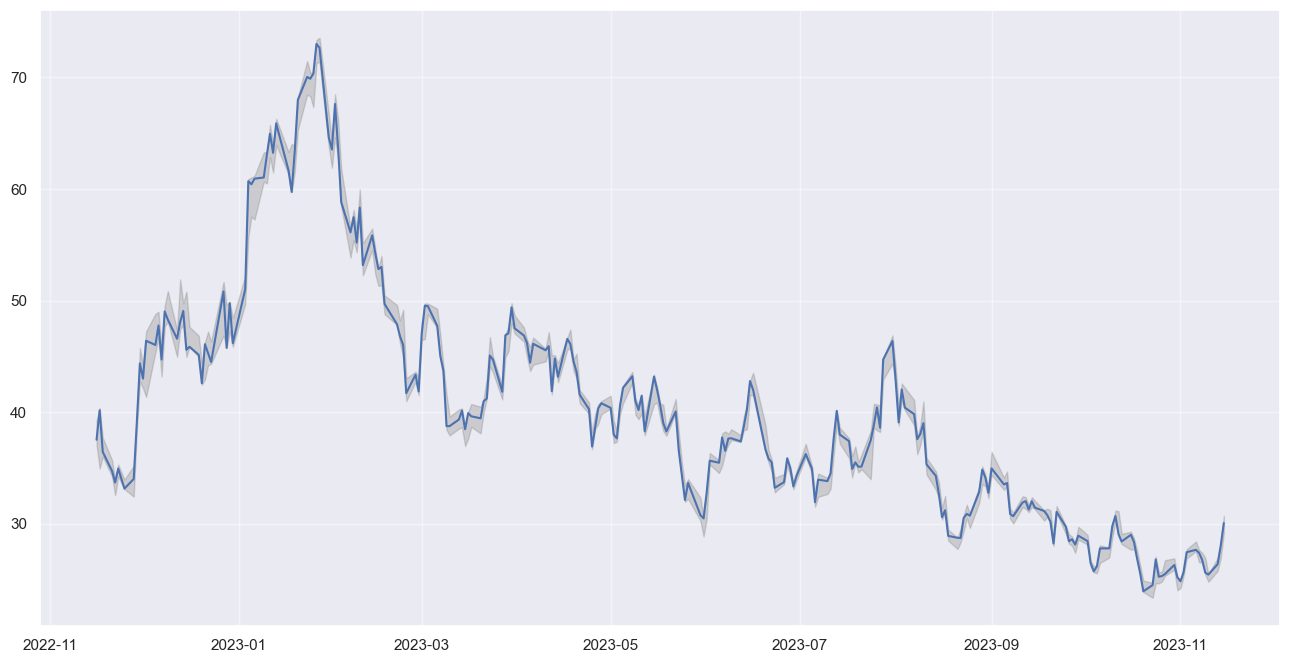

In [29]:
df_yinn = yf.download('yinn'.upper(), start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
df_yinn = df_yinn.reset_index()

plt.figure(figsize=(16, 8))
plt.grid(True, alpha=0.5)

plt.plot(df_yinn['Date'], df_yinn['Close'], label='Daily Close Price')
# plt.plot(df_yinn['Date'], df_yinn['High'], color='green', label='Highest Price')
# plt.plot(df_yinn['Date'], df_yinn['Low'], color='red', label='Lowest Price')

# Shading the region between the highest and lowest prices
plt.fill_between(df_yinn['Date'], df_yinn['Low'], df_yinn['High'], color='gray', alpha=0.3, label='Daily Price Range')
plt.show()

In [30]:
df_yinn.columns = df_yinn.columns.str.lower()
df_yinn.head()


,date,open,high,low,close,adj close,volume
0,2022-11-16,39.009998,39.220001,37.080002,37.520000,36.657555,1192000
1,2022-11-17,35.220001,40.349998,34.930000,40.160000,39.236866,2714600
2,2022-11-18,37.700001,37.700001,36.009998,36.430000,35.592609,1956700
3,2022-11-21,34.970001,35.689999,34.220001,34.720001,33.921917,1166300
4,2022-11-22,33.060001,33.939999,32.549999,33.680000,32.905823,1396900


In [31]:
# Example usage:
# Assuming you have a DataFrame named 'stock_price_dataframe' with a 'close' column
df_yinn = identify_weak_support_resistance(df_yinn)
df_yinn

,date,open,high,low,close,adj close,volume,Support/Resistance
0,2022-11-16,39.009998,39.220001,37.080002,37.520000,36.657555,1192000,neither
1,2022-11-17,35.220001,40.349998,34.930000,40.160000,39.236866,2714600,weak resistance
2,2022-11-18,37.700001,37.700001,36.009998,36.430000,35.592609,1956700,neither
3,2022-11-21,34.970001,35.689999,34.220001,34.720001,33.921917,1166300,neither
4,2022-11-22,33.060001,33.939999,32.549999,33.680000,32.905823,1396900,weak support
...,...,...,...,...,...,...,...,...
246,2023-11-09,26.549999,26.950001,25.420000,25.610001,25.610001,2559400,neither
247,2023-11-10,25.150000,25.490000,24.790001,25.430000,25.430000,3481200,weak support
248,2023-11-13,26.030001,26.910000,25.760000,26.360001,26.360001,3667000,neither
249,2023-11-14,27.049999,28.309999,26.920000,28.030001,28.030001,5647500,neither


Optimum K is  9
Optimum K is  9
[[25.02999992]
 [28.37199974]
 [31.10571398]
 [33.89199982]
 [38.00999936]
 [42.01874971]
 [45.4744445 ]
 [54.32249928]
 [61.73250008]
 [69.87999725]]
[[27.87500032]
 [31.30666669]
 [34.91800003]
 [39.59599991]
 [42.90714264]
 [46.09199944]
 [50.08142907]
 [58.08500099]
 [66.14999898]
 [71.52000046]]


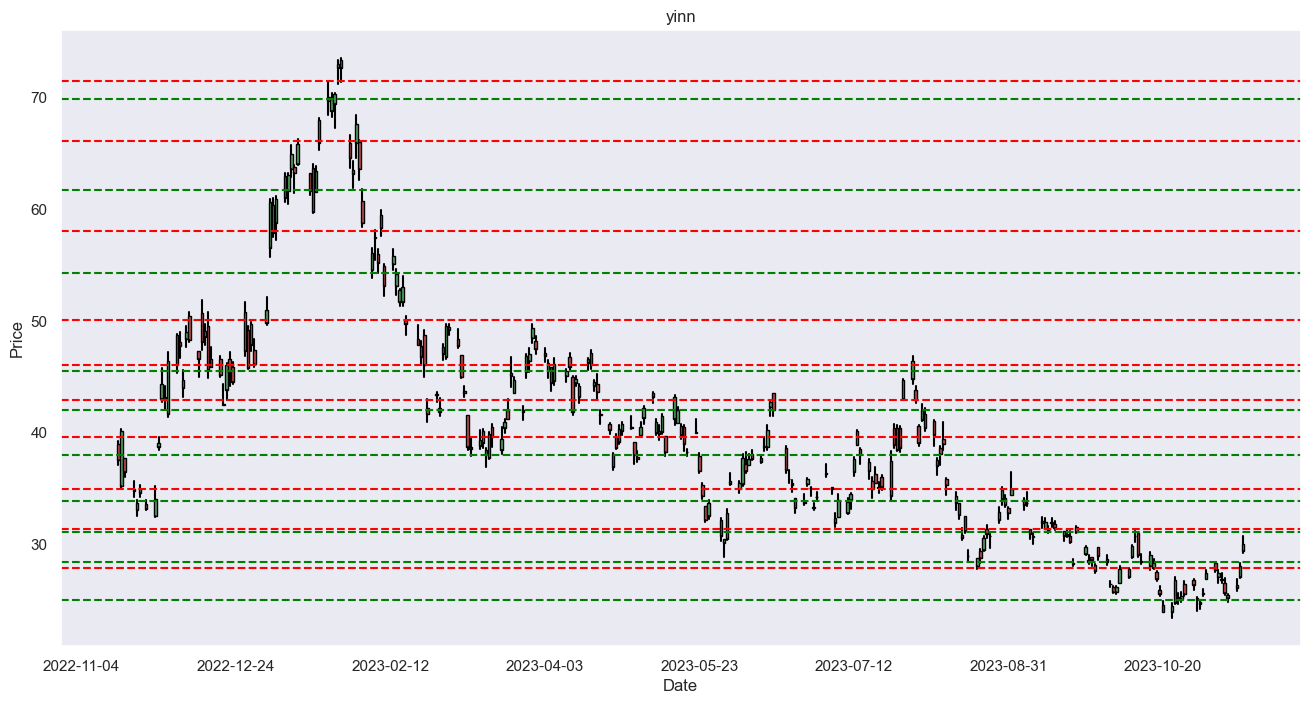

In [32]:
low_clusters = get_optimum_clusters(df_yinn[df_yinn['Support/Resistance']=='weak support'][['date',"close"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_yinn[df_yinn['Support/Resistance']=='weak resistance'][['date',"close"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

ax = plot_candlestick(df_yinn)
ax.set_title('yinn')
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')

Optimum K is 10
Optimum K is 10
[[23.40399984]
 [27.98679985]
 [31.13461538]
 [34.12205876]
 [37.79261916]
 [41.57685689]
 [46.11948727]
 [54.76846137]
 [62.39083354]
 [69.3519989 ]]
[[25.2383337 ]
 [30.4838891 ]
 [34.8559461 ]
 [38.46000015]
 [41.48170713]
 [46.12242415]
 [49.9913637 ]
 [56.41250038]
 [63.72933324]
 [70.84428733]]


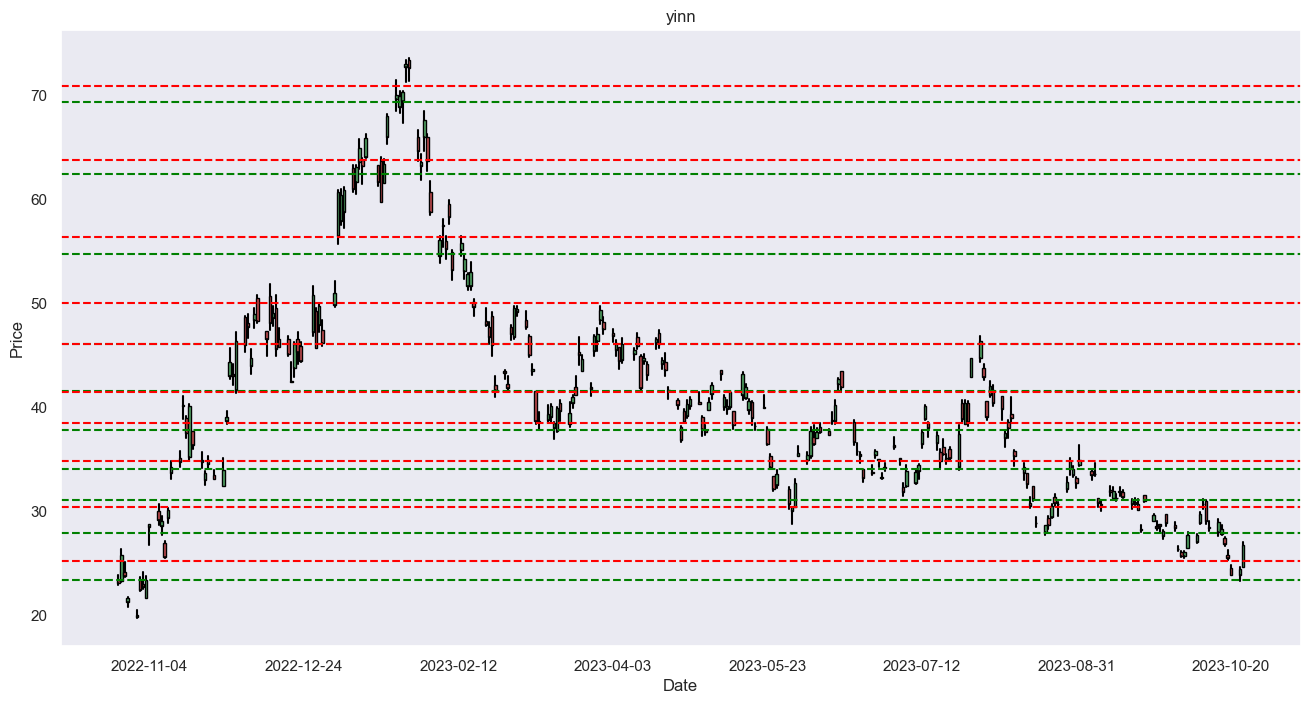

In [11]:
low_clusters = get_optimum_clusters(df_yinn[(df_yinn['low']!=df_yinn['open'])&(df_yinn['low']!=df_yinn['close'])][['date',"low"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_yinn[(df_yinn['high']!=df_yinn['open'])&(df_yinn['high']!=df_yinn['close'])][['date',"high"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

ax = plot_candlestick(df_yinn)
ax.set_title('yinn')
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')

[*********************100%%**********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
[[203.86399841]
 [228.66061566]
 [251.23263229]
 [273.86233476]
 [285.3151735 ]
 [297.08043985]
 [309.18032963]
 [321.88757602]
 [340.17447765]
 [355.75964519]]
[[207.50999908]
 [231.85854783]
 [255.33657052]
 [277.68519462]
 [288.8525823 ]
 [302.63230685]
 [313.42934029]
 [325.46810831]
 [344.50070491]
 [360.67092669]]


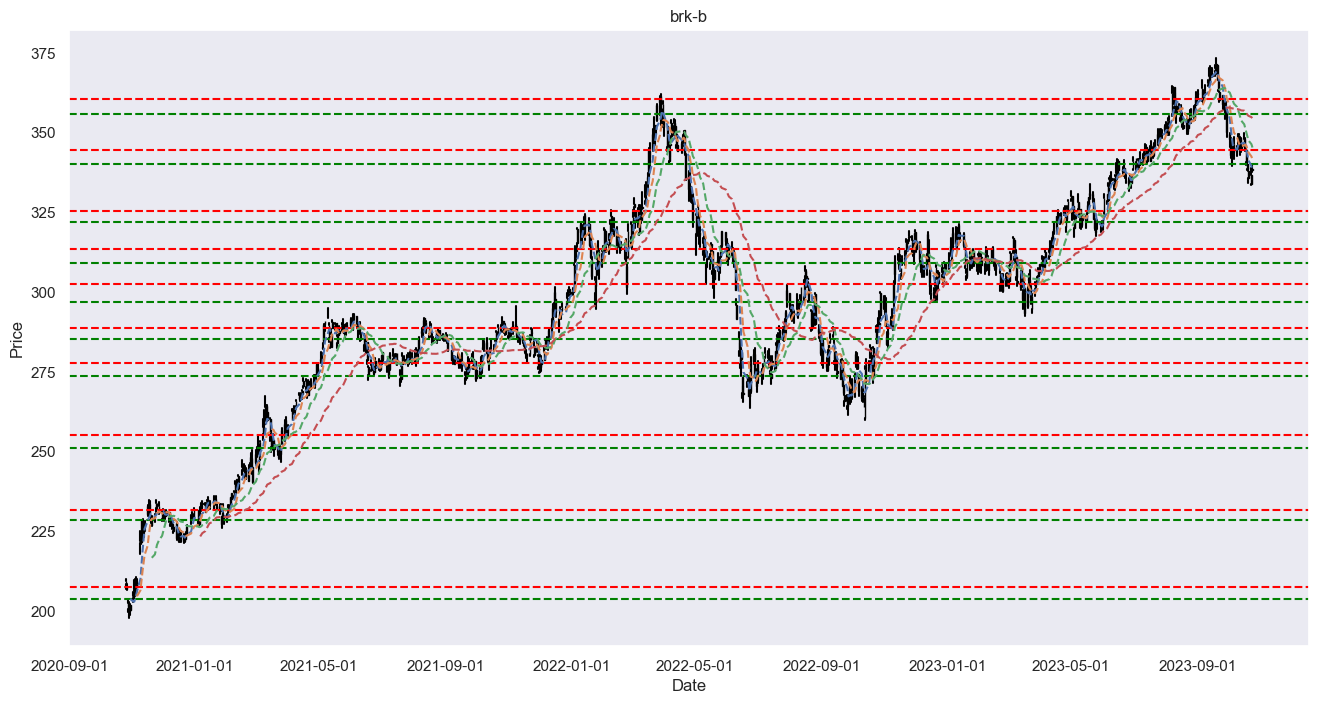

In [12]:
df_brk = yf.download('brk-b'.upper(), start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
df_brk = df_brk.reset_index()
df_brk.columns = df_brk.columns.str.lower()

df_brk = identify_weak_support_resistance(df_brk)
low_clusters = get_optimum_clusters(df_brk[(df_brk['low']!=df_brk['open'])&(df_brk['low']!=df_brk['close'])][['date',"low"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_brk[(df_brk['high']!=df_brk['open'])&(df_brk['high']!=df_brk['close'])][['date',"high"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

ax = plot_candlestick(df_brk)
ax.set_title('brk-b')
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')
    
df_brk['5_MA'] = df_brk['close'].rolling(window=5).mean()
df_brk['9_MA'] = df_brk['close'].rolling(window=9).mean()
df_brk['20_MA'] = df_brk['close'].rolling(window=20).mean()
df_brk['50_MA'] = df_brk['close'].rolling(window=50).mean()

ax.plot(df_brk['date'], df_brk['5_MA'], ls='--')

ax.plot(df_brk['date'], df_brk['9_MA'], ls='--')
ax.plot(df_brk['date'], df_brk['20_MA'], ls='--')
ax.plot(df_brk['date'], df_brk['50_MA'], ls='--')

Optimum K is 10
Optimum K is 10
[[203.43499756]
 [227.7150007 ]
 [246.1257128 ]
 [266.97636275]
 [276.14351592]
 [287.077778  ]
 [305.91151567]
 [319.10427856]
 [340.97105006]
 [356.12727217]]
[[206.63000488]
 [231.65266622]
 [254.88142831]
 [277.44564037]
 [288.75214059]
 [305.46521792]
 [316.38615183]
 [329.78866984]
 [347.13176593]
 [362.05299988]]


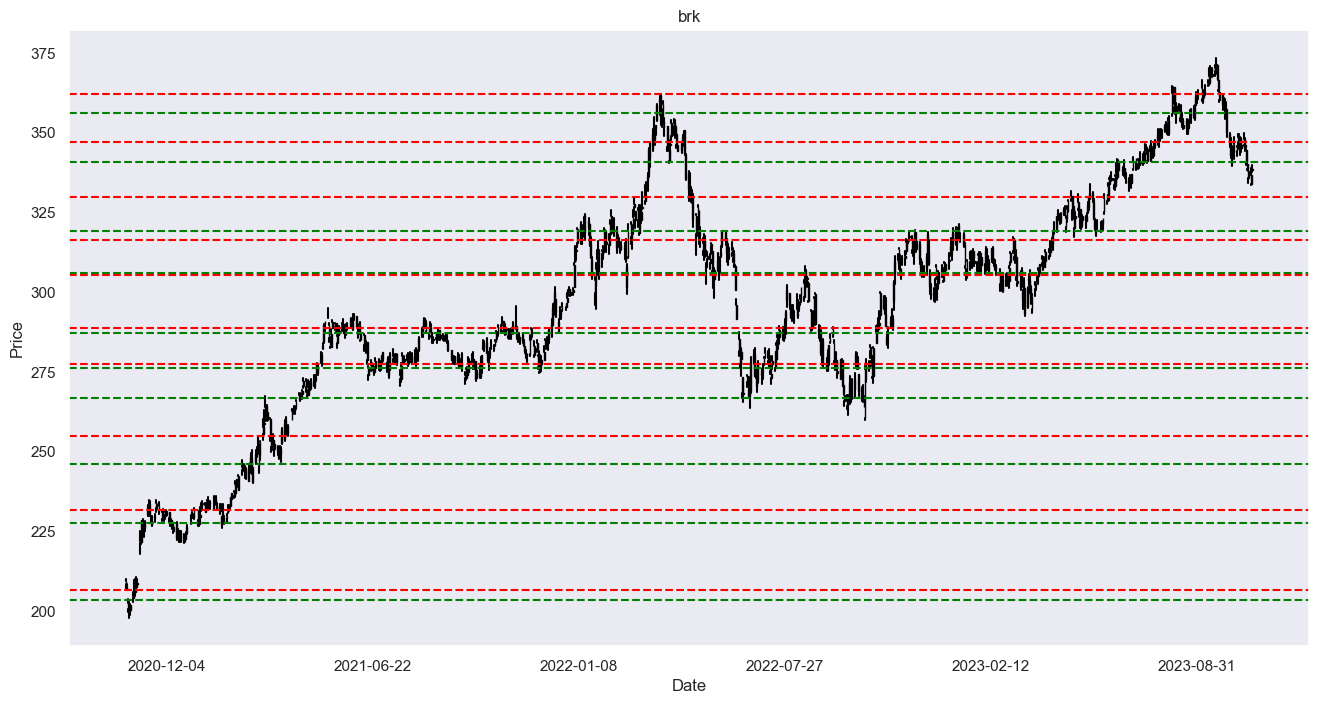

In [13]:
low_clusters = get_optimum_clusters(df_brk[df_brk['Support/Resistance']=='weak support'][['date',"close"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_brk[df_brk['Support/Resistance']=='weak resistance'][['date',"close"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

ax = plot_candlestick(df_brk)
ax.set_title('brk')
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')

[*********************100%%**********************]  1 of 1 completed
Optimum K is 10
Optimum K is 10
[[304.0399971 ]
 [332.12999971]
 [346.82482408]
 [360.17901761]
 [374.90158655]
 [384.12472988]
 [394.46844165]
 [404.72901055]
 [414.63095929]
 [428.79558404]]
[[312.45699463]
 [337.61981812]
 [351.7533792 ]
 [362.48977176]
 [371.41492519]
 [381.98630668]
 [393.24960124]
 [404.94874954]
 [416.1845993 ]
 [431.9710022 ]]


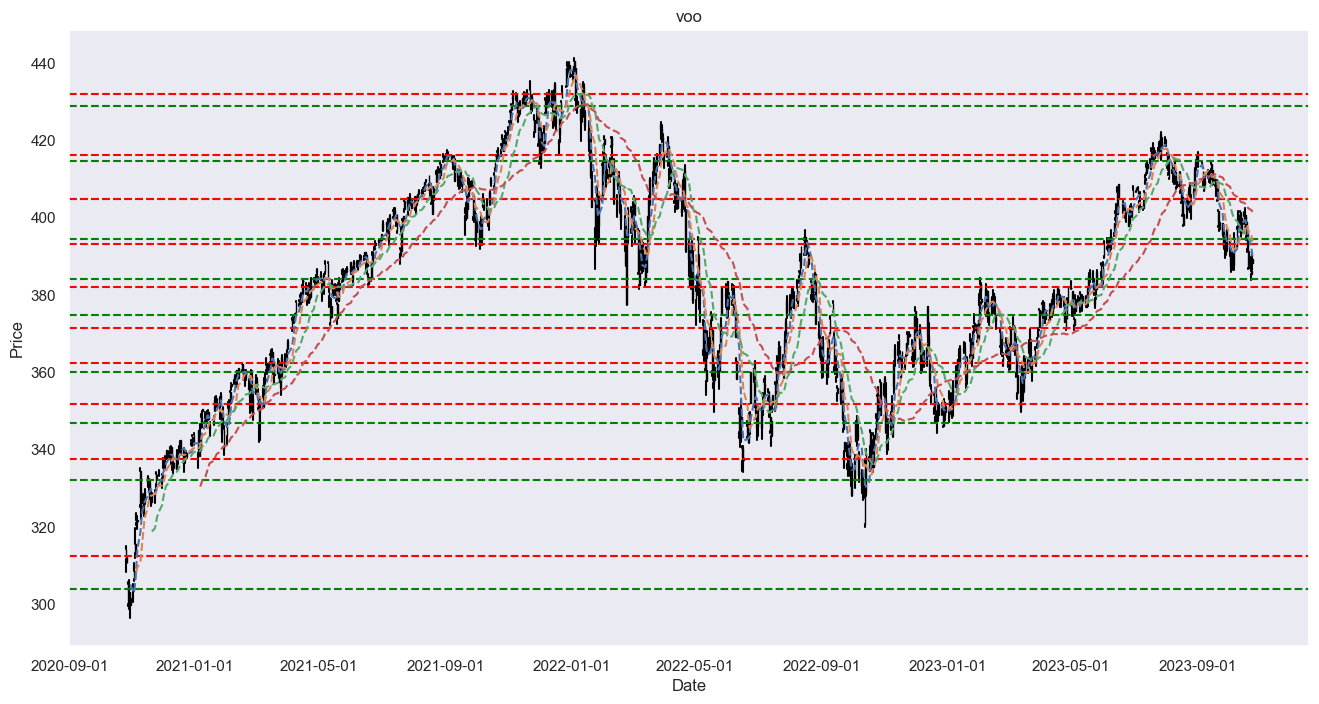

In [14]:
df_voo = yf.download('voo'.upper(), start=(datetime.today() - relativedelta(years=3)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))
df_voo = df_voo.reset_index()
df_voo.columns = df_voo.columns.str.lower()

df_voo = identify_weak_support_resistance(df_voo)
low_clusters = get_optimum_clusters(df_voo[(df_voo['low']!=df_voo['open'])&(df_voo['low']!=df_voo['close'])][['date',"low"]].set_index('date'))
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(df_voo[(df_voo['high']!=df_voo['open'])&(df_voo['high']!=df_voo['close'])][['date',"high"]].set_index('date'))
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

ax = plot_candlestick(df_voo)
ax.set_title('voo')
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--')
    
df_voo['5_MA'] = df_voo['close'].rolling(window=5).mean()
df_voo['9_MA'] = df_voo['close'].rolling(window=9).mean()
df_voo['20_MA'] = df_voo['close'].rolling(window=20).mean()
df_voo['50_MA'] = df_voo['close'].rolling(window=50).mean()

ax.plot(df_voo['date'], df_voo['5_MA'], ls='--')

ax.plot(df_voo['date'], df_voo['9_MA'], ls='--')
ax.plot(df_voo['date'], df_voo['20_MA'], ls='--')
ax.plot(df_voo['date'], df_voo['50_MA'], ls='--')

In [ ]:
def find_strong_level(df):
    closest_preceding = {}
    closest_following = {}

    last_supp_index = None
    last_resi_index = None
    
    for i, (gender, height) in enumerate(student_list):
        if gender == 'g':
            # If the current student is a girl, find the closest preceding boy
            if last_boy_index is not None:
                closest_preceding[i] = last_boy_index
            # Update the most recent girl index
            last_girl_index = i
        elif gender == 'b':
            # If the current student is a boy, find the closest preceding girl
            if last_girl_index is not None:
                closest_preceding[i] = last_girl_index
            # Update the most recent boy index
            last_boy_index = i

    # Reset the variables for tracking the most recent students
    last_girl_index = None
    last_boy_index = None

    # Iterate in reverse to find the closest following students
    for i in range(len(student_list) - 1, -1, -1):
        gender, height = student_list[i]
        if gender == 'g':
            # If the current student is a girl, find the closest following boy
            if last_boy_index is not None:
                closest_following[i] = last_boy_index
            # Update the most recent girl index
            last_girl_index = i
        elif gender == 'b':
            # If the current student is a boy, find the closest following girl
            if last_girl_index is not None:
                closest_following[i] = last_girl_index
            # Update the most recent boy index
            last_boy_index = i

    # Create a list of students with the desired format
    students_with_heights = []
    for i, (gender, height) in enumerate(student_list):
        preceding_height = student_list[closest_preceding.get(i, -1)][1] if closest_preceding.get(i, -1) != -1 else None
        following_height = student_list[closest_following.get(i, -1)][1] if closest_following.get(i, -1) != -1 else None
        students_with_heights.append([gender, height, preceding_height, following_height])

    return students_with_heights

# Example usage:
student_list = [('g', 170), ('b', 180), ('g', 160), ('b', 175), ('b', 185), ('g', 165)]
find_closest_students_with_heights(student_list)

In [ ]:
df2 = pd.DataFrame()

# Number of previous days to include
num_prev_days = 10

# Loop through the dates in df_kweb
for i, row in df_kweb[df_kweb['date']>='2023-07-01'].iterrows():
    date = row['date']
    price = row['close']
    
    # Create columns for each previous day's price
    for day in range(num_prev_days):
        prev_date = date - pd.Timedelta(days=day + 1)
        prev_price = df_kweb.loc[df_kweb['date'] == prev_date, 'close'].values
        
        # Add the previous day's price to the new dataframe
        col_name = f'price_{-day - 1}day'
        df2.at[i, col_name] = prev_price[0] if len(prev_price) > 0 else None
    
    # Add the current day's price to the new dataframe
    df2.at[i, 'price_0day'] = price

# Merge the date column from df_kweb with df2
df2['date'] = df_kweb[df_kweb['date']>='2023-07-01']['date']

# Reorder the columns to have 'date' first
column_order = ['date'] + [f'price_{-day}day' for day in range(num_prev_days)]
df2 = df2[column_order]

print(df2)

In [ ]:
df2.head()